# Step-by-step DA for the basin

### Classes and modules

In [1]:
#Lets have matplotlib "inline"
%matplotlib inline

import os
import sys

#Import packages we need
import numpy as np
import datetime
from IPython.display import display
import copy

#For plotting
import matplotlib
from matplotlib import pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable

plt.rcParams["lines.color"] = "w"
plt.rcParams["text.color"] = "w"
plt.rcParams["axes.labelcolor"] = "w"
plt.rcParams["xtick.color"] = "w"
plt.rcParams["ytick.color"] = "w"

plt.rcParams["image.origin"] = "lower"

import pycuda.driver as cuda

GPU Ocean-modules:

In [2]:
from gpuocean.utils import IPythonMagic, Common

In [3]:
%cuda_context_handler gpu_ctx

In [4]:
gpu_stream = cuda.Stream()

Basin utils

In [5]:
sys.path.insert(0, os.path.abspath(os.path.join(os.getcwd(), '../')))
from utils.BasinInit import *

## Data Assimilation

In [6]:
ls = [6, 7, 8, 9, 10]

In [7]:
args_list = []

for l in ls:
    lvl_grid_args = initGridSpecs(l)
    args_list.append( {
        "nx": lvl_grid_args["nx"],
        "ny": lvl_grid_args["ny"],
        "dx": lvl_grid_args["dx"],
        "dy": lvl_grid_args["dy"],
        "gpu_ctx": gpu_ctx,
        "gpu_stream": gpu_stream,
        "boundary_conditions": Common.BoundaryConditions(2,2,2,2)
        } )

In [8]:
from utils.BasinParameters import *

In [9]:
data_args_list = []
for l_idx in range(len(args_list)): #TODO: Check indices 
    data_args_list.append( make_init_steady_state(args_list[l_idx], a=steady_state_bump_a, bump_fractal_dist=steady_state_bump_fractal_dist) )


### Truth

In [10]:
from gpuocean.SWEsimulators import ModelErrorKL
true_init_mekl = ModelErrorKL.ModelErrorKL(**args_list[-1], **init_model_error_basis_args)
true_sim_mekl = ModelErrorKL.ModelErrorKL(**args_list[-1], **sim_model_error_basis_args)

truth = make_sim(args_list[-1], sample_args=sample_args, init_fields=data_args_list[-1])
true_init_mekl.perturbSim(truth)
truth.model_error = true_sim_mekl
truth.model_time_step = sim_model_error_timestep

In [11]:
true_eta, true_hu, true_hv = truth.download(interior_domain_only=True)

In [12]:
from utils.BasinSL import *
Hx, Hy = SLobsCoord2obsIdx([truth],obs_xs[0], obs_ys[0])

In [13]:
obs_xs[0], obs_ys[0]

(40040.0, 80040.0)

In [14]:
Hx, Hy

(500, 1000)

In [15]:
obs = np.array([true[Hy, Hx] for true in [true_eta, true_hu, true_hv]]) + np.random.multivariate_normal(np.zeros(3), np.diag(R))

Text(0.5, 0.85, 'Truth')

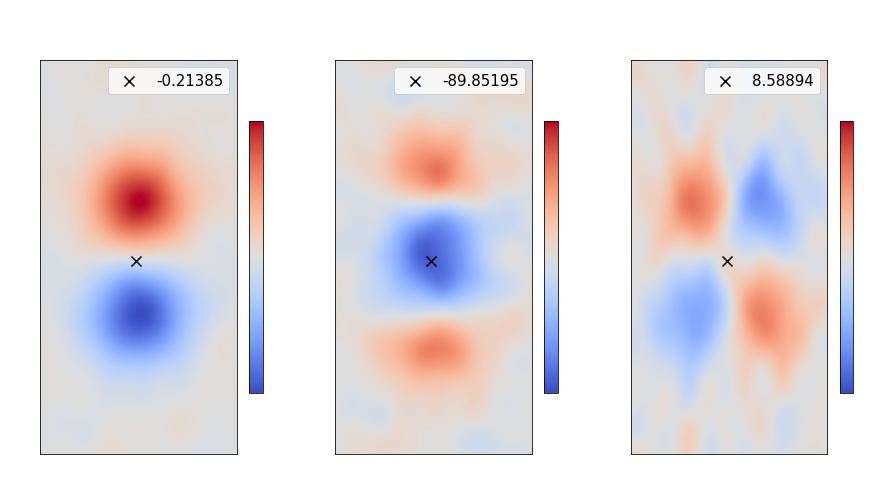

In [16]:
from utils.BasinPlot import *

fig, axs = imshow3([true_eta, true_hu, true_hv])
axs[0].scatter(Hx,Hy, marker="x", c="black", label=str(round(obs[0],5)), s=100)
axs[0].legend(labelcolor="black", fontsize=15)
axs[1].scatter(Hx, Hy, marker="x", c="black", label=str(round(obs[1],5)), s=100)
axs[1].legend(labelcolor="black", fontsize=15)
axs[2].scatter(Hx, Hy, marker="x", c="black", label=str(round(obs[2],5)), s=100)
axs[2].legend(labelcolor="black", fontsize=15)
fig.suptitle("Truth", y=0.85)

### Multi-level Ensemble

In [17]:
Nes = [100, 75, 50, 25, 10]

In [18]:
from utils.BasinEnsembleInit import *

ML_ensemble = initMLensemble(Nes, args_list, data_args_list, sample_args, init_model_error_basis_args, sim_model_error_basis_args, sim_model_error_timestep)

In [19]:
from gpuocean.ensembles import MultiLevelOceanEnsemble

MLOceanEnsemble = MultiLevelOceanEnsemble.MultiLevelOceanEnsemble(ML_ensemble)

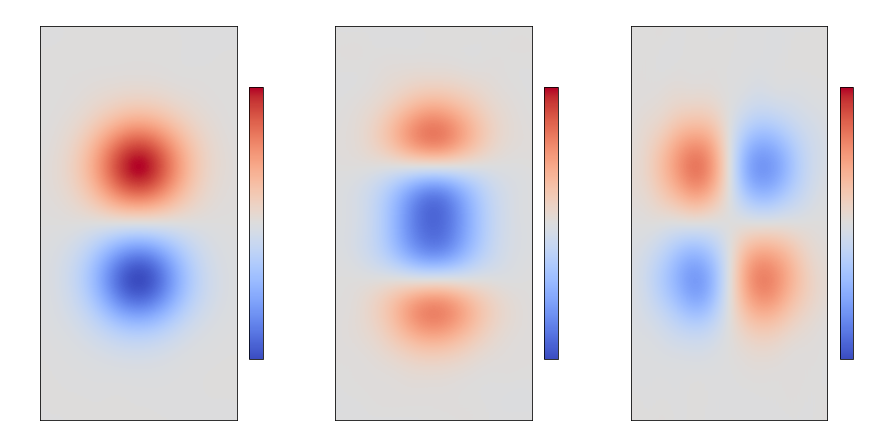

In [20]:
fig, axs = imshow3(MLOceanEnsemble.estimate(np.mean))

(<Figure size 1080x720 with 6 Axes>,
 array([<AxesSubplot:title={'center':'$\\eta$'}>,
        <AxesSubplot:title={'center':'$hu$'}>,
        <AxesSubplot:title={'center':'$hv$'}>], dtype=object))

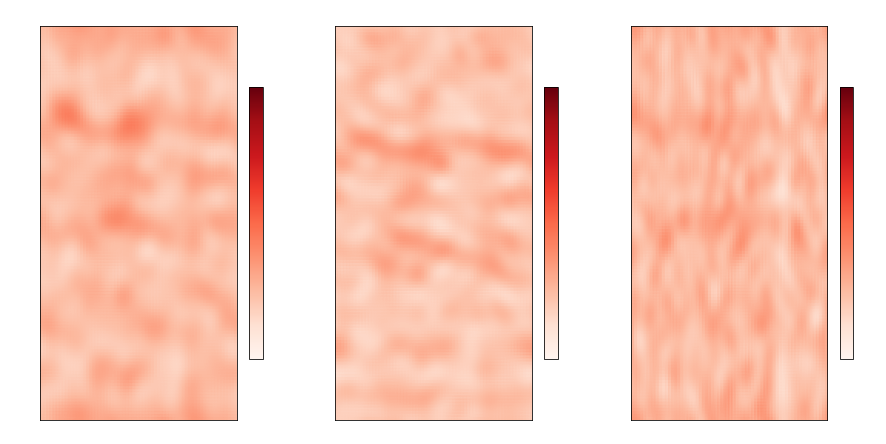

In [21]:
imshow3var(MLOceanEnsemble.estimate(np.var))

### Kalman gain

Localisation weights

In [22]:
Xs = np.linspace(0.5*MLOceanEnsemble.dxs[-1], (MLOceanEnsemble.nxs[-1] - 0.5) * MLOceanEnsemble.dxs[-1], MLOceanEnsemble.nxs[-1])
Ys = np.linspace(0.5*MLOceanEnsemble.dys[-1], (MLOceanEnsemble.nys[-1] - 0.5) * MLOceanEnsemble.dys[-1], MLOceanEnsemble.nys[-1])
X, Y = np.meshgrid(Xs, Ys)

xdim = MLOceanEnsemble.dxs[-1] * MLOceanEnsemble.nxs[-1]
ydim = MLOceanEnsemble.dys[-1] * MLOceanEnsemble.nys[-1]

/home/florianb/miniconda3/envs/gpuocean_opendrift/lib/python3.7/site-packages/ipykernel_launcher.py:63: RuntimeWarning: divide by zero encountered in true_divide


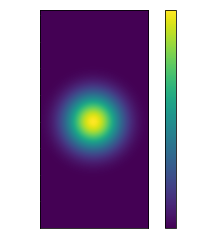

In [23]:
obs_x, obs_y = obs_xs[0], obs_ys[0]

if (MLOceanEnsemble.boundary_conditions.north == 2) \
    or (MLOceanEnsemble.boundary_conditions.south == 2) \
    or (MLOceanEnsemble.boundary_conditions.west == 2) \
    or (MLOceanEnsemble.boundary_conditions.east == 2):

    from scipy.spatial.distance import cdist

    if (MLOceanEnsemble.boundary_conditions.north == 2) \
        and (MLOceanEnsemble.boundary_conditions.south == 2) \
        and (MLOceanEnsemble.boundary_conditions.west == 2) \
        and (MLOceanEnsemble.boundary_conditions.east == 2):

        assert r < xdim/2 and r < ydim/2, "Localisation radius too large"

        def _calculate_distance(coord1, coord2, xdim, ydim):
            distx = np.abs(coord1[0] - coord2[0])
            disty = np.abs(coord1[1] - coord2[1])
            distx = np.minimum(distx, xdim - distx)
            disty = np.minimum(disty, ydim - disty)
            return np.sqrt(distx**2 + disty**2)
        
    elif (MLOceanEnsemble.boundary_conditions.north == 2) \
        and (MLOceanEnsemble.boundary_conditions.south == 2) \
        and (MLOceanEnsemble.boundary_conditions.west != 2) \
        and (MLOceanEnsemble.boundary_conditions.east != 2):

        assert r < ydim/2, "Localisation radius too large"

        def _calculate_distance(coord1, coord2, xdim, ydim):
            distx = np.abs(coord1[0] - coord2[0])
            disty = np.abs(coord1[1] - coord2[1])
            disty = np.minimum(disty, ydim - disty)
            return np.sqrt(distx**2 + disty**2)
        
    elif (MLOceanEnsemble.boundary_conditions.north != 2) \
        and (MLOceanEnsemble.boundary_conditions.south != 2) \
        and (MLOceanEnsemble.boundary_conditions.west == 2) \
        and (MLOceanEnsemble.boundary_conditions.east == 2):

        assert r < xdim/2, "Localisation radius too large"

        def _calculate_distance(coord1, coord2, xdim, ydim):
            distx = np.abs(coord1[0] - coord2[0])
            disty = np.abs(coord1[1] - coord2[1])
            distx = np.minimum(distx, xdim - distx)
            return np.sqrt(distx**2 + disty**2)
    
    else:
        assert False, "Invalid boundary conditions" 

    grid_coordinates = np.vstack((X.flatten(), Y.flatten())).T
    dists = cdist(grid_coordinates, np.atleast_2d([obs_x, obs_y]),
                    lambda u, v: _calculate_distance(u, v, xdim, ydim))
    dists = dists.reshape(X.shape)

else:
    dists = np.sqrt((X - obs_x)**2 + (Y - obs_y)**2)

GC = np.zeros_like(dists)
GC = np.where(dists/r < 1, 1 - 5/3*(dists/r)**2 + 5/8*(dists/r)**3 + 1/2*(dists/r)**4 - 1/4*(dists/r)**5, GC)
GC = np.where(np.logical_and((dists/r >= 1), (dists/r < 2)), 4 - 5*(dists/r) + 5/3*(dists/r)**2 + 5/8*(dists/r)**3 -1/2*(dists/r)**4 + 1/12*(dists/r)**5 - 2/(3*(dists/r)), GC)

plt.imshow(GC, vmin=0, vmax=1.0)
plt.colorbar()

In [24]:
r, xdim, ydim

(25000.0, 81920.0, 163840.0)

Preparations

In [25]:
numLevels = len(ls)

In [26]:
# obs_var = slice(0,1) # eta
obs_var = slice(1,3) # hu and hv
# obs_var = slice(0,3) # eta, hu, hv

In [27]:
if obs_var.step is None:
    obs_varN = (obs_var.stop - obs_var.start) 
else: 
    obs_varN = (obs_var.stop - obs_var.start)/obs_var.step

In [28]:
ML_state = MLOceanEnsemble.download()

In [29]:
ML_prior = copy.deepcopy(ML_state)

In [30]:
lvl_X, lvl_Y = [], []
for l_idx in range(len(MLOceanEnsemble.Nes)):
    lvl_Xs = np.linspace(0.5*MLOceanEnsemble.dxs[l_idx], (MLOceanEnsemble.nxs[l_idx] - 0.5) * MLOceanEnsemble.dxs[l_idx], MLOceanEnsemble.nxs[l_idx])
    lvl_Ys = np.linspace(0.5*MLOceanEnsemble.dys[l_idx], (MLOceanEnsemble.nys[l_idx] - 0.5) * MLOceanEnsemble.dys[l_idx], MLOceanEnsemble.nys[l_idx])
    new_lvl_X, new_lvl_Y = np.meshgrid(lvl_Xs, lvl_Ys)
    lvl_X.append(new_lvl_X)
    lvl_Y.append(new_lvl_Y)

In [31]:
obs_idxs = [list(np.unravel_index(np.argmin((lvl_X[0] - obs_x)**2 + (lvl_Y[0] - obs_y)**2), ML_state[0][0].shape[:-1]))]
for l_idx in range(1, len(Nes)):
    obs_idxs0 = np.unravel_index(np.argmin((lvl_X[l_idx]   - obs_x)**2 + (lvl_Y[l_idx]   - obs_y)**2), ML_state[l_idx][0][0].shape[:-1])
    obs_idxs1 = np.unravel_index(np.argmin((lvl_X[l_idx-1] - obs_x)**2 + (lvl_Y[l_idx-1] - obs_y)**2), ML_state[l_idx][1][0].shape[:-1])
    obs_idxs.append([list(obs_idxs0), list(obs_idxs1)])


In [32]:
obs_idxs

[[62, 31],
 [[125, 62], [62, 31]],
 [[250, 125], [125, 62]],
 [[500, 250], [250, 125]],
 [[1000, 500], [500, 250]]]

Covariances

In [33]:
ML_XY = np.zeros((np.prod(ML_state[-1][0].shape[:-1]),obs_varN))

In [34]:
X0 = ML_state[0]
X0mean = np.average(X0, axis=-1)

Y0 = ML_state[0][obs_var,obs_idxs[0][0],obs_idxs[0][1]]
Y0mean = np.average(Y0, axis=-1)[:,np.newaxis]

ML_XY += (1/Nes[0]*(
            (X0-X0mean[:,:,:,np.newaxis]).reshape(-1,Nes[0]) 
            @ (Y0 - Y0mean).T)
         ).reshape(X0mean.shape + (obs_varN,)).repeat(2**(numLevels-1),1).repeat(2**(numLevels-1),2).reshape(-1,obs_varN)

In [35]:
for l_idx in range(1,len(ls)):

    X0 = ML_state[l_idx][0]
    X0mean = np.average(X0, axis=-1)
    X1 = ML_state[l_idx][1].repeat(2,1).repeat(2,2)
    X1mean = np.average(X1, axis=-1)

    Y0 = ML_state[l_idx][0][obs_var,obs_idxs[l_idx][0][0],obs_idxs[l_idx][0][1]]
    Y0mean = np.average(Y0, axis=-1)[:,np.newaxis]
    Y1 = ML_state[l_idx][1][obs_var,obs_idxs[l_idx][1][0],obs_idxs[l_idx][1][1]]
    Y1mean = np.average(Y1, axis=-1)[:,np.newaxis]

    ML_XY += ( ( 1/Nes[l_idx]*(
                  (X0-X0mean[:,:,:,np.newaxis]).reshape(-1,Nes[l_idx]) @ (Y0 - Y0mean).T) 
                 - 1/Nes[l_idx]*(
                  (X1-X1mean[:,:,:,np.newaxis]).reshape(-1,Nes[l_idx]) @ (Y1 - Y1mean).T) 
                )
             ).reshape(X0mean.shape + (obs_varN,)).repeat(2**(numLevels-l_idx-1),1).repeat(2**(numLevels-l_idx-1),2).reshape(-1,obs_varN)


In [36]:
ML_HXY = ML_XY.reshape(ML_state[-1][0].shape[:-1] + (obs_varN,))[obs_var,obs_idxs[-1][0][0],obs_idxs[-1][0][1],:]
ML_YY  = ML_HXY + np.diag(R[obs_var])

ML_K = ML_XY @ np.linalg.inv(ML_YY)

Text(0.5, 0.9, 'Kalman Gain')

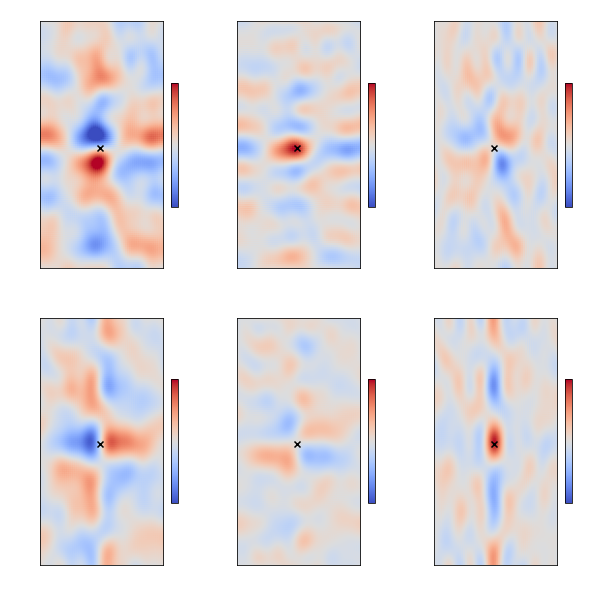

In [37]:
ML_K_field = ML_K.reshape(ML_state[-1][0].shape[:-1] + (obs_varN,))

vlims = [[1, 0.01, 0.01],[10, 1, 1],[10, 1, 1]]

fig, axs = plt.subplots(obs_varN,3, figsize=(10,5*obs_varN))
for i in range(obs_var.start, obs_var.stop):
    for j in range(3):
        
        if obs_varN == 1:
            ax = axs[j]
        elif obs_varN > 1:
            ax = axs[i-obs_var.start,j]
            
        im = ax.imshow(ML_K_field[j,:,:,i-obs_var.start], vmin=-vlims[j][i],vmax=vlims[j][i], cmap="coolwarm")
        ax.scatter(Hx, Hy, marker="x", c="black")
        plt.colorbar(im, ax=ax, shrink=0.5)

fig.suptitle("Kalman Gain", y=0.9)

### Update

In [38]:
from skimage.measure import block_reduce

In [39]:
ML_perts = []
for l_idx in range(len(ls)):
    ML_perts.append(np.random.multivariate_normal(np.zeros(3)[obs_var], np.diag(R[obs_var]), size=Nes[l_idx]))

In [40]:
ML_posterior = [] 
ML_posterior.append( 
    ML_prior[0] + (block_reduce( ML_K.reshape(ML_state[-1][0].shape[:-1]+ (obs_varN,)),  block_size=(1,2**(numLevels-1), 2**(numLevels-1), 1), func=np.mean).reshape((np.prod(ML_state[0].shape[:-1]),obs_varN)) 
                 @ (obs[obs_var,np.newaxis] - ML_prior[0][obs_var,obs_idxs[0][0],obs_idxs[0][1]] - ML_perts[0].T)
                ).reshape(ML_state[0].shape)
)
    
for l_idx in range(1,len(ls)):

    ML_posterior.append(
        [ ML_prior[l_idx][0] + (block_reduce(ML_K.reshape(ML_state[-1][0].shape[:-1]+ (obs_varN,)), block_size=(1,2**(numLevels-l_idx-1), 2**(numLevels-l_idx-1), 1), func=np.mean).reshape((np.prod(ML_state[l_idx][0].shape[:-1]),obs_varN)) 
                                               @ (obs[obs_var,np.newaxis] - ML_prior[l_idx][0][obs_var,obs_idxs[l_idx][0][0],obs_idxs[l_idx][0][1]] - ML_perts[l_idx].T)
                                              ).reshape(ML_state[l_idx][0].shape), 
        ML_prior[l_idx][1] + (block_reduce(ML_K.reshape(ML_state[-1][0].shape[:-1]+ (obs_varN,)), block_size=(1,2**(numLevels-l_idx  ), 2**(numLevels-l_idx  ), 1), func=np.mean).reshape((np.prod(ML_state[l_idx][1].shape[:-1]),obs_varN)) 
                                               @ (obs[obs_var,np.newaxis] - ML_prior[l_idx][1][obs_var,obs_idxs[l_idx][1][0],obs_idxs[l_idx][1][1]] - ML_perts[l_idx].T)
                                              ).reshape(ML_state[l_idx][1].shape)]
    )


In [41]:
MLOceanEnsemble.upload(ML_posterior)

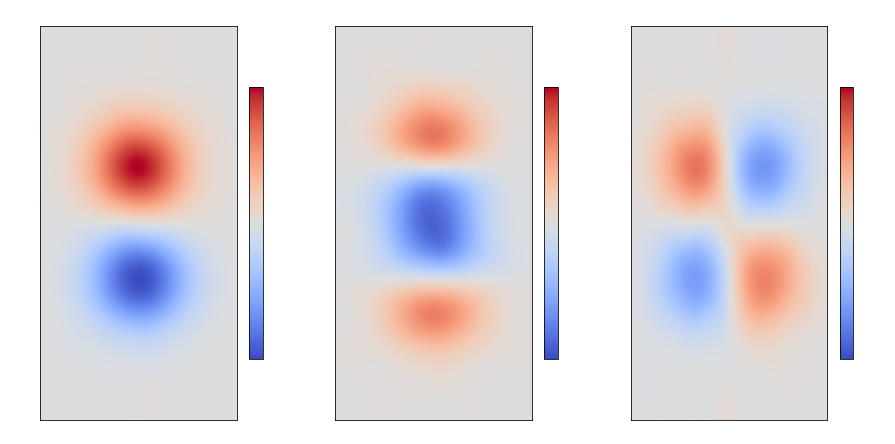

In [42]:
fig, axs = imshow3(MLOceanEnsemble.estimate(np.mean))
# fig.suptitle("Posterior ML mean", y=0.9)

(<Figure size 1080x720 with 6 Axes>,
 array([<AxesSubplot:title={'center':'$\\eta$'}>,
        <AxesSubplot:title={'center':'$hu$'}>,
        <AxesSubplot:title={'center':'$hv$'}>], dtype=object))

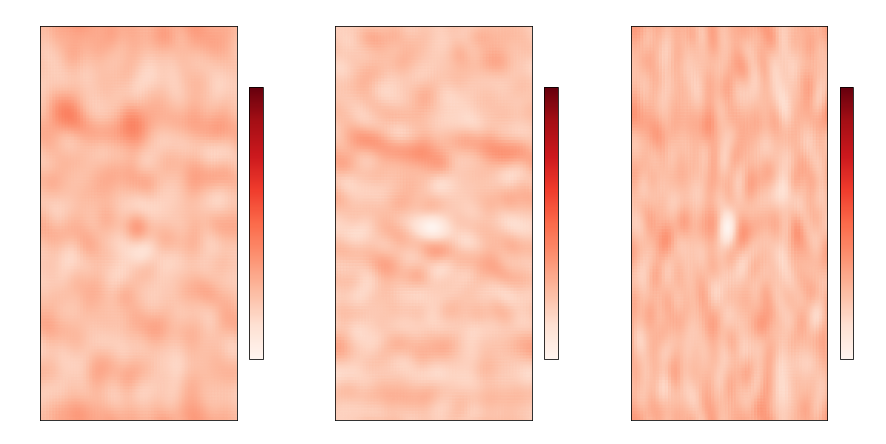

In [43]:
imshow3var(MLOceanEnsemble.estimate(np.var))

In [45]:
def ML_diff(ML1, ML2):
    assert len(ML1) == len(ML2), "Both states need to have same number of levels"
    assert len(ML1[0]) == len(ML2[0]), "The levels have to have same number of member in both states"
    for l in range(1,len(ML1)):
        assert len(ML1[l][0]) == len(ML2[l][0]), "The levels have to have same number of member in both states"
        assert len(ML1[l][1]) == len(ML2[l][1]), "The levels have to have same number of member in both states"
    MLdiff = copy.deepcopy(ML1)
    
    MLdiff[0] = MLdiff[0] - ML2[0]
    for l in range(1,len(ML1)):
        MLdiff[l][0] = MLdiff[l][0] - ML2[l][0]
        MLdiff[l][1] = MLdiff[l][1] - ML2[l][1]
    
    return MLdiff

(<Figure size 1080x720 with 6 Axes>,
 array([<AxesSubplot:title={'center':'$\\eta$'}>,
        <AxesSubplot:title={'center':'$hu$'}>,
        <AxesSubplot:title={'center':'$hv$'}>], dtype=object))

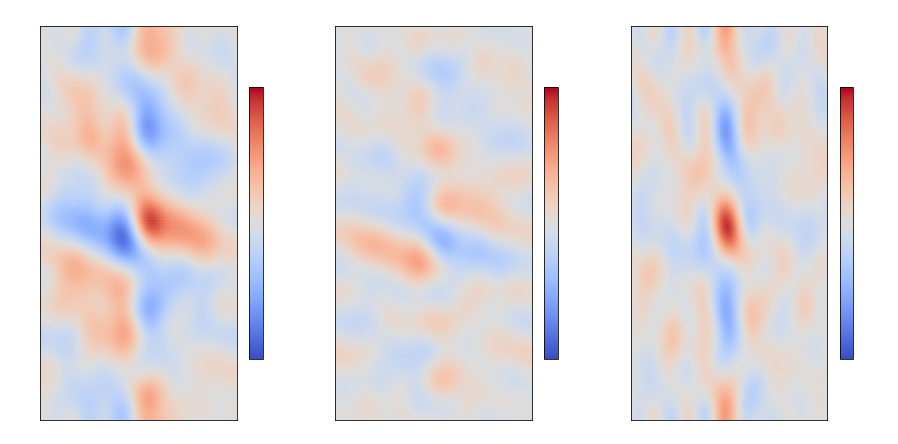

In [48]:
MLOceanEnsemble.upload(ML_diff(ML_posterior, ML_prior))
imshow3(MLOceanEnsemble.estimate(np.mean), eta_vlim=0.1, huv_vlim=10)